Run batch file to download Greenland Ice Sheet liquid discharge data from [Mankoff and others (2020)](https://dataverse.geus.dk/dataset.xhtml?persistentId=doi:10.22008/FK2/XKQVL7&version=5.0)

In [ ]:
!cd ../data/runoff/ & runoff_download.bat

Load, merge, and average MAR and RACMO runoff datasets

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr

# Read runoff basins and glacier centrelines
basins = gpd.read_file("../data/runoff/runoff_freshwater_ice_basins.gpkg")
centrelines = gpd.read_file("../data/misc/centreline_lines.geojson")

# Find largest basin that intersects each centreline and extract its ID
basin_join = basins.sjoin(centrelines)
basin_selection = basin_join.loc[basin_join.groupby("index_right").area.idxmax()]
basin_ids = basin_selection.cat.values

# Load MAR data and subset by glaciers and time range of interest
mar_ds = xr.open_dataset("../data/runoff/runoff_freshwater_ice_mar.nc")
mar_ds = mar_ds.where(mar_ds.station.isin(basin_ids), drop=True).expand_dims(model=["MAR"])
mar_ds = mar_ds.sel(time=slice("1985-01-01", "2024-01-01"))

# Load RACMO data and subset by glaciers and time range of interest
racmo_ds = xr.open_dataset("../data/runoff/runoff_freshwater_ice_racmo.nc")
racmo_ds = racmo_ds.where(racmo_ds.station.isin(basin_ids), drop=True).expand_dims(model=["RACMO"])
racmo_ds = racmo_ds.sel(time=slice("1985-01-01", "2024-01-01"))

# Merge MAR and RACMO data and take average of runoff from both datasets
runoff_ds = xr.combine_by_coords([mar_ds, racmo_ds], combine_attrs="drop_conflicts")
runoff_ds["discharge_model_average"] = runoff_ds.discharge.mean(dim="model")

# Re-index with glacier name and drop unnecessary variables
runoff_ds = runoff_ds.assign_coords(glacier=("station", np.unique(runoff_ds.M2019_basin.values)))
runoff_ds = runoff_ds.swap_dims(dict(station="glacier"))
runoff_ds = runoff_ds.assign_coords(basin_area=("glacier", basin_selection.area.values))
runoff_ds = runoff_ds[["discharge", "discharge_model_average", "basin_area"]]

# Write to disk
runoff_ds.to_netcdf("../data/runoff/runoff_1985_2024.nc")
runoff_ds

<xarray.Dataset> Size: 777kB
Dimensions:                  (model: 2, glacier: 2, time: 13879)
Coordinates:
    basin_area               (glacier) float64 16B 5.238e+10 3.016e+09
  * model                    (model) object 16B 'MAR' 'RACMO'
    alt                      (glacier) float32 8B -496.0 -180.0
    lat                      (glacier) float32 8B 71.93 67.44
    lon                      (glacier) float32 8B -28.57 -33.55
    station                  (glacier) uint64 16B 45600 65479
  * time                     (time) datetime64[ns] 111kB 1985-01-01 ... 2022-...
  * glacier                  (glacier) object 16B 'DAUGAARD-JENSEN' 'UNNAMED_...
Data variables:
    discharge                (model, glacier, time) float64 444kB 6.61e-13 .....
    discharge_model_average  (glacier, time) float64 222kB 0.03517 ... 1.215
Attributes:
    featureType:      timeSeries
    title:            Greenland discharge
    summary:          Greenland RCM discharge at basin outlets
    keywords:         Hydrology; Greenland; Runoff; Discharge; Freshwater
    Conventions:      CF-1.7
    source:           git commit: 0be7e36
    creator_name:     Ken Mankoff
    creator_email:    kdm@geus.dk
    creator_url:      http://kenmankoff.com
    institution:      GEUS
    references:       10.22008/promice/freshwater
    product_version:  1.0

Calculate and visualise cumulative runoff and cumulative runoff normalised by basin area

In [2]:
runoff_cumulative = runoff_ds.groupby(runoff_ds.time.dt.year).cumsum()
runoff_cumulative = runoff_cumulative.where(runoff_ds.time.dt.is_year_start != True)
runoff_cumulative["glacier"] = runoff_ds.glacier

runoff_cumulative_normalised = runoff_cumulative / runoff_cumulative.basin_area

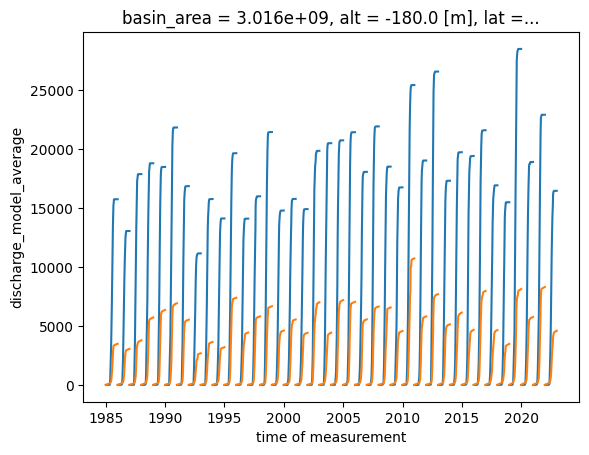

In [3]:
runoff_cumulative.isel(glacier=0).discharge_model_average.plot()
runoff_cumulative.isel(glacier=1).discharge_model_average.plot()

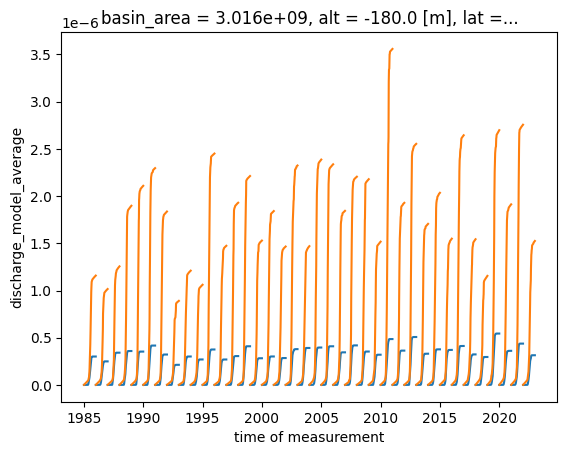

In [4]:
runoff_cumulative_normalised.isel(glacier=0).discharge_model_average.plot()
runoff_cumulative_normalised.isel(glacier=1).discharge_model_average.plot()

Linear regression of runoff against time 

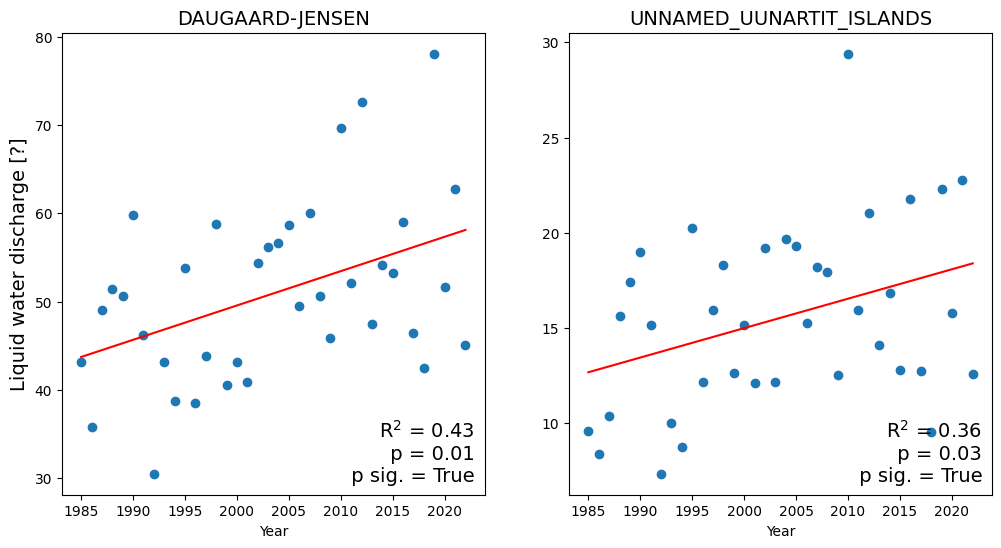

In [240]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load discharge data
runoff_ds = xr.open_dataset("../data/runoff/runoff_1985_2024.nc")

for i, (glacier, ds) in enumerate(runoff_ds.groupby("glacier", squeeze=False)):
    # Resample runoff to annual means and extract years
    runoff = ds.discharge_model_average.resample(time="1YS").mean().squeeze()
    years = runoff.time.dt.year

    # Mask null values
    mask = runoff.notnull() & years.notnull()
    runoff = runoff.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress discharge against year
    res = scipy.stats.linregress(years, runoff)

    # Plot data and trendline
    axs[i].plot(years, runoff, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
            loc="lower right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Liquid water discharge [?]", size=14)

plt.show()

Plot cumulative runoff and basin-normalised cumulative runoff

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Set up axes
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(nrows=2, ncols=1)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
axs = [ax0, ax1]

# Read runoff time series
runoff_ds = xr.open_dataset("../data/runoff/runoff_1985_2024.nc")

# Plot data for each glacier in turn
for glacier, ds in runoff_ds.groupby("glacier", squeeze=False):
    runoff_cumulative = ds.groupby(runoff_ds.time.dt.year).cumsum()
    runoff_cumulative = runoff_cumulative.where(runoff_ds.time.dt.is_year_start != True)
    runoff_cumulative["glacier"] = ds.glacier

    runoff_cumulative_normalised = runoff_cumulative / runoff_cumulative.basin_area

    # Plot monthly mean surface air temperature
    axs[0].plot(
        runoff_cumulative.discharge_model_average.time,
        runoff_cumulative.discharge_model_average.squeeze(),
        color=PLOT_SETTINGS[glacier]["colour"][0],
        linewidth=2,
        label=PLOT_SETTINGS[glacier]["label"],
    )
    axs[0].fill_between(
        runoff_cumulative.discharge_model_average.time,
        runoff_cumulative.sel(model="RACMO").discharge.squeeze(),
        runoff_cumulative.sel(model="MAR").discharge.squeeze(),
        color=PLOT_SETTINGS[glacier]["colour"][0],
        alpha=0.5,
    )

    # Plot anomalies of monthly mean surface air temperature
    axs[1].plot(
        runoff_cumulative_normalised.discharge_model_average.time,
        runoff_cumulative_normalised.discharge_model_average.squeeze(),
        linestyle="-",
        linewidth=2,
        color=PLOT_SETTINGS[glacier]["colour"][0],
        label=PLOT_SETTINGS[glacier]["label"],
    )
    axs[1].fill_between(
        runoff_cumulative_normalised.discharge_model_average.time,
        runoff_cumulative_normalised.sel(model="RACMO").discharge.squeeze(),
        runoff_cumulative_normalised.sel(model="MAR").discharge.squeeze(),
        color=PLOT_SETTINGS[glacier]["colour"][0],
        alpha=0.5,
    )

# Set y-axis range to fit data and add label
axs[0].set_ylim(bottom=0, top=30_000)
axs[0].set_ylabel("Cumulative runoff [m$^3$ s$^{-1}$]", labelpad=20)
axs[1].set_ylim(bottom=0, top=5e-6)
axs[1].set_ylabel("Cumulative runoff normalised\n by basin area [m s$^{-1}$]", labelpad=20)

# Set x-axis range to fit data
axs[0].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))
axs[1].set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))

# Format x-axis ticks: text format, frequency, rotation
axs[0].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[0].xaxis.set_major_locator(YearLocator(5))
axs[0].xaxis.set_minor_locator(YearLocator(1))
axs[0].tick_params(labelbottom=False)
axs[1].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[1].xaxis.set_major_locator(YearLocator(5))
axs[1].xaxis.set_minor_locator(YearLocator(1))
axs[1].tick_params(axis="x", rotation=70)

# Remove margin gap
axs[0].margins(x=0)
axs[1].margins(x=0)

# Draw horizontal line at y=0
axs[0].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
axs[1].axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Draw grid
axs[0].grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
axs[1].grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)

# Draw axes label
axs[0].add_artist(AnchoredText("(a)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))
axs[1].add_artist(AnchoredText("(b)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))


plt.tight_layout()
plt.savefig("../img/ts_runoff.png", dpi=fig.dpi, bbox_inches="tight")
plt.show()